# Finding Causality in Big Data: An Introduction

### Shirin Mojarad, Ph.D.
### Data Scientist, McGraw-Hill Education

@shirinmojarad

Shirin.mojarad@gmail.com

https://github.com/Lewkow/LAK_2017_Workshop

# Agenda 

* Introduction to causality
* How to establish causality
* Randomized controlled trials
* Causal inference
* Your Toolkit For Finding Causality

# Your Toolkit For Finding Causality

# Causal Inference in 5 Steps

<ol type="1">
<li>Identify covariates from observational data</li>
<li>Choose a matching metric </li>
<li>Execute a matching algorithm</li>
<li>Examine covariate balance</li>
<li>Estimate treatment effects </li>
</ol>

# Data

We want to study the effect of a training program on individuals’ earnings.

* Data are from the National Supported Work Demonstration (NSWD) and the Current Population Survey (Dehejia and Wahba survey 2002)
* Treatment is if a person received training 
* Independent variables are age, education, marrital status, earnings in 1974 and 1975, employement status in 1974 and 1975
* Outcome is real earnings in 1978 (RE78)
* We need to find matches for the 185 treated observations and then compare outcomes

## Import required libraries and data

In [2]:
import pandas as pd
import numpy as np
import statsmodels.stats.api as sms
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import binom, hypergeom, gaussian_kde
from scipy.stats import ttest_ind
import math
from scipy.stats import binom, hypergeom, gaussian_kde
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('matching_earnings_1.csv')
print(df.shape)
df.head()

(2675, 11)


,TREAT,AGE,EDUC,BLACK,MARR,NODEGREE,RE74,RE75,U74,U75,EARNINGS
0,0,40,8,0,1,1,50940.9,55500.0,0,0,53198.2
1,0,54,0,0,1,1,49228.5,44221.0,0,0,20540.4
2,0,47,10,0,1,1,48198.0,47968.1,0,0,55710.3
3,0,32,8,0,1,1,47022.4,67137.1,0,0,59109.1
4,0,47,8,0,1,1,44667.4,33837.1,0,0,38568.7


In [84]:
print ('Number of treated units: %d' %df.groupby('TREAT').size()[1])
print ('Number of control units: %d' %df.groupby('TREAT').size()[0])

Number of treated units: 185
Number of control units: 2490


Note from the output that not all of the control observations might be used as matches for the 185 treated observations.

## Convert numeric columns to integer type

In [85]:
# several numeric columns are shown with type object instead of integer
df.dtypes

TREAT         int64
AGE           int64
EDUC          int64
BLACK         int64
MARR          int64
NODEGREE      int64
RE74        float64
RE75        float64
U74           int64
U75           int64
EARNINGS    float64
dtype: object

In [86]:
# function to convert dataframe column types to float
def convertFloat(data):
    for attribute in data.columns:
        data[attribute] = data[attribute].astype(float) 
    return data

In [87]:
# apply the above function
df = convertFloat(df)

## Define treatment, outcome and covariates

In [88]:
# treatment
Tr = df.TREAT

# outcome
Y = df.EARNINGS
Y0 = df.EARNINGS[df.TREAT==0]
Y1 = df.EARNINGS[df.TREAT==1]

# covariates
X = df[['AGE', 'EDUC', 'MARR','NODEGREE','RE74','RE75','U74','U75']]

# 1 Identify covariates from observational data
## 1.1 Difference-in-means: outcome variable

* Effectiveness of treatment (effect on RE78 expression)
* Question: does treatment affect RE78 expression (outcome)?

In [89]:
df.groupby('TREAT')['EARNINGS'].mean().reset_index()

,TREAT,EARNINGS
0,0.0,21553.921332
1,1.0,6349.145368


In [90]:
# Mean difference 
print ('Differene in means: $'+ str(int(Y1.mean() - Y0.mean())) )

Differene in means: $-15204


It seems that individuals who did not receive training earn $15k on average more than those who received the training.

In [91]:
# t-statistic & p-value for difference in outcome of two groups
def hypothesisTest(data, attribute, group):
    x = data[attribute][df[group]==1]
    y = data[attribute][df[group]==0]
    # t-statistic & p-value for difference in outcome of two groups
    t = ttest_ind(x, y)[0]
    p = ttest_ind(x, y)[1]
    # Confidence intervals
    cm = sms.CompareMeans(sms.DescrStatsW(x), sms.DescrStatsW(y))
    CI = str(round(cm.tconfint_diff(usevar='unequal')[0]))+' - '+str(round(cm.tconfint_diff(usevar='unequal')[1]))
    # Cohen's d
    pooledvar = math.sqrt((pow(x.std(),2) + (pow(y.std(),2)))/2)
    d = (x.mean()-y.mean()) / pooledvar
    # create dataframe
    tablelist = []
    tablerow = [attribute,x.mean()-y.mean(),t,p,CI,d]
    tablelist.append(tablerow)
    out = pd.DataFrame(tablelist)
    out.columns = ['Attribute','Mean Difference','t-value','p-value','95% Confidence Intervals',"Cohen's d"]

    return out

In [92]:
hypothesisTest(df, 'EARNINGS', 'TREAT')

,Attribute,Mean Difference,t-value,p-value,95% Confidence Intervals,Cohen's d
0,EARNINGS,-15204.775965,-13.168705,2.032910e-38,-16498.0 - -13912.0,-1.233544


The difference-in-means is significant and the effect size is large.

# 1.3 Difference-in-means: pre-treatment covariates
### We’ll work with the following covariates:

* Age
* Education
* Race (Black/White)
* Marital status
* Whether or not the subject has a college degree
* Whether or not the subject was unemployed in 1974 and 1975
* Earnings in 1974 and 1975

Let’s get the difference-in-means for each of these covariates, by the treatment status:

In [93]:
def plotDisribution(data, attribute, groups):
    f, ax = plt.subplots(figsize=(10, 6))
    pre = pd.DataFrame({'groups':data[groups], 'propensity':data[attribute]})    

    density0 = gaussian_kde(pre.propensity[pre.groups==0])
    density1 = gaussian_kde(pre.propensity[pre.groups==1])
    xs = np.linspace(0,data[attribute].max(),1000)
    ax.plot(xs,density0(xs),color='blue')
    ax.fill_between(xs,density1(xs),color='gray')
    ax.set_title('Before Matching')
    ax.set_xlabel(attribute)
    ax.set_ylabel('Density')

    gray_patch = mpatches.Patch(color='gray', label='Treated')
    blue_patch = mpatches.Patch(color='blue', label='Not Treated')
    plt.legend(handles=[gray_patch,blue_patch], loc='center left',bbox_to_anchor=(1, 0.5),fontsize=8)
  
    return(f)

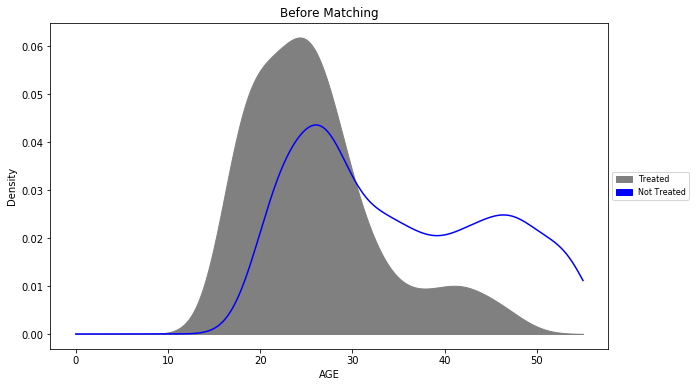

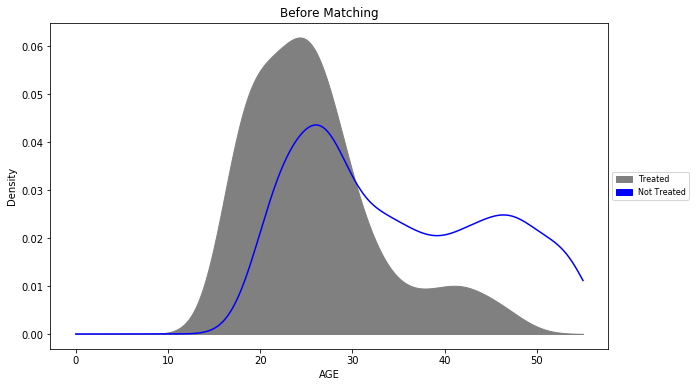

In [94]:
f=plotDisribution(df,'AGE', 'TREAT'); display(f)

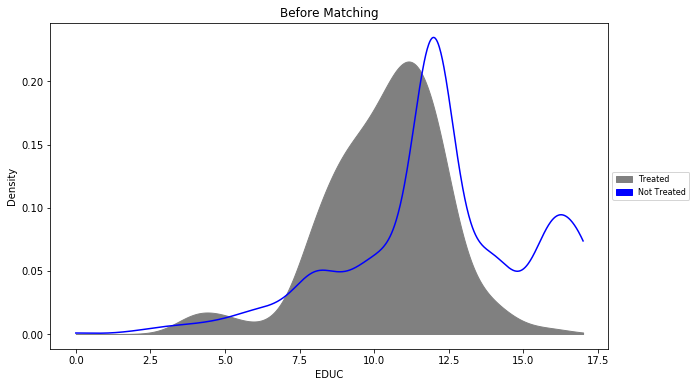

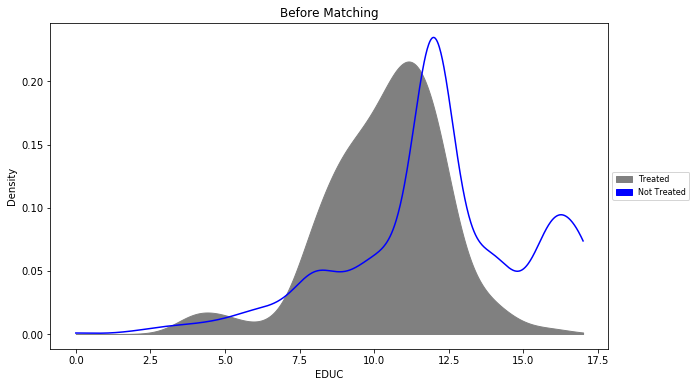

In [95]:
f=plotDisribution(df,'EDUC', 'TREAT'); display(f)

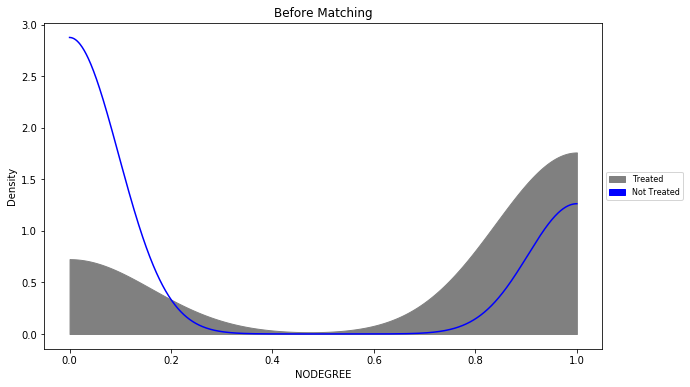

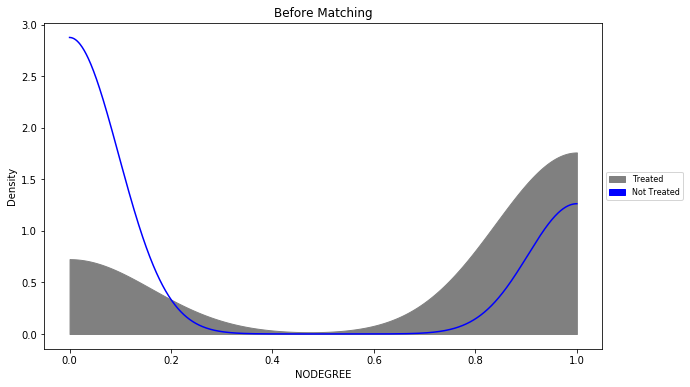

In [96]:
# Exercise: plot the distribution for the rest of covariate for treatment and control groups
f=plotDisribution(df,'NODEGREE', 'TREAT'); display(f)

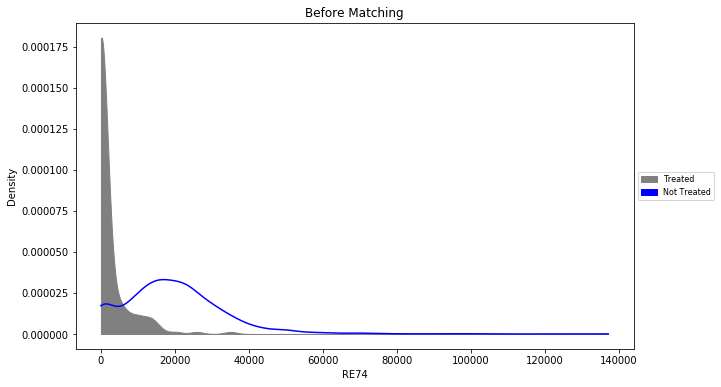

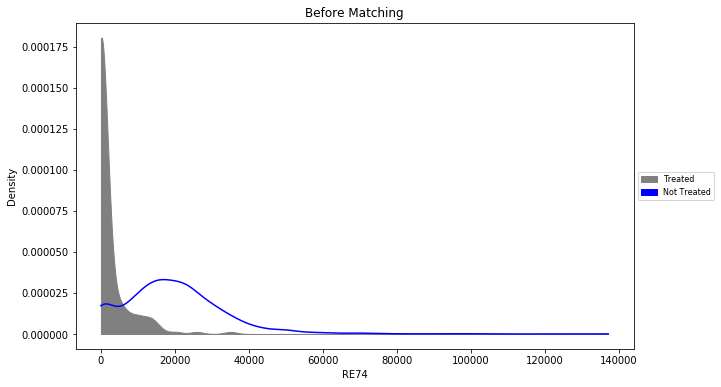

In [97]:
f=plotDisribution(df,'RE74', 'TREAT'); display(f)

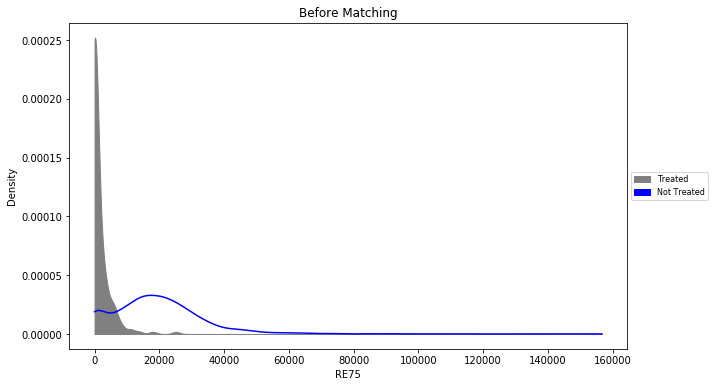

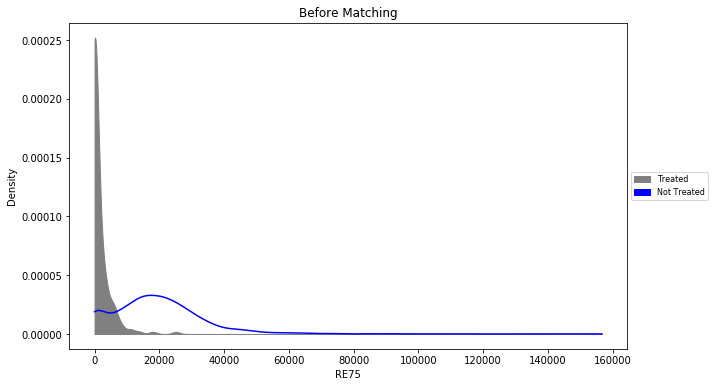

In [98]:
f=plotDisribution(df,'RE75', 'TREAT'); display(f)

In [99]:
# difference of means for each attribute, by treatment group
df.groupby('TREAT').mean().reset_index()

,TREAT,AGE,EDUC,BLACK,MARR,NODEGREE,RE74,RE75,U74,U75,EARNINGS
0,0.0,34.850602,12.116867,0.250602,0.866265,0.305221,19428.745305,19063.336753,0.086345,0.1,21553.921332
1,1.0,25.816216,10.345946,0.843243,0.189189,0.708108,2095.574000,1532.055630,0.708108,0.6,6349.145368


* What do you see? Take a moment to reflect on what these differences suggest for the relationship of interest (that between treated and not treated).

We can carry out t-tests to evaluate whether these means are statistically distinguishable:

In [100]:
b = pd.DataFrame()
for att in X:
    a = []
    a = hypothesisTest(df, att, 'TREAT')
    b = pd.concat([b,a],0)
b

,Attribute,Mean Difference,t-value,p-value,95% Confidence Intervals,Cohen's d
0,AGE,-9.034386,-11.568216,3.094941e-30,-10.0 - -8.0,-1.009433
0,EDUC,-1.770922,-7.692919,2.007808e-14,-2.0 - -1.0,-0.680517
0,MARR,-0.677076,-25.806985,2.561532e-131,-1.0 - -1.0,-1.842335
0,NODEGREE,0.402887,11.486689,7.627033e-30,0.0 - 0.0,0.879213
0,RE74,-17333.171305,-17.496005,5.604172e-65,-18215.0 - -16451.0,-1.717826
0,RE75,-17531.281123,-17.497851,5.443565e-65,-18240.0 - -16823.0,-1.774367
0,U74,0.621763,27.536942,3.648032e-147,1.0 - 1.0,1.642096
0,U75,0.500000,20.702414,1.989532e-88,0.0 - 1.0,1.228422


## 2 Propensity score matching

Match treated and untreated observations on the estimated probability of being treated (propensity score)

P(X) = Pr (Tr=1|X)

We can estimate the propensity scores using logistic regression.

In [101]:
####### Using GLM
import statsmodels.genmod.generalized_linear_model as sm
glm_binom = sm.GLM(Tr, X, family=sm.families.Binomial())
res = glm_binom.fit()
print (res.summary())
propensityScoreGLM = res.fittedvalues
df = pd.concat([df[['TREAT']],X,df[['EARNINGS']],propensityScoreGLM],1)
df.columns = np.concatenate(( ['TREAT'],X.columns,['EARNINGS' ,'Propensity Score']), axis=0)
print ('\n'+ 'Propensity Scores added: ')
df.head()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  TREAT   No. Observations:                 2675
Model:                            GLM   Df Residuals:                     2667
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -248.03
Date:                Tue, 18 Jun 2019   Deviance:                       496.06
Time:                        08:58:08   Pearson chi2:                 6.15e+03
No. Iterations:                    10                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
AGE           -0.0809      0.013     -6.342      0.000      -0.106      -0.056
EDUC           0.0828      0.029      2.862      0.0

,TREAT,AGE,EDUC,MARR,NODEGREE,RE74,RE75,U74,U75,EARNINGS,Propensity Score
0,0.0,40.0,8.0,1.0,1.0,50940.9,55500.0,0.0,0.0,53198.2,1.175500e-07
1,0.0,54.0,0.0,1.0,1.0,49228.5,44221.0,0.0,0.0,20540.4,3.155578e-07
2,0.0,47.0,10.0,1.0,1.0,48198.0,47968.1,0.0,0.0,55710.3,4.917539e-07
3,0.0,32.0,8.0,1.0,1.0,47022.4,67137.1,0.0,0.0,59109.1,1.157987e-08
4,0.0,47.0,8.0,1.0,1.0,44667.4,33837.1,0.0,0.0,38568.7,1.330150e-05


## 3 Execute a matching algorithm

There are several variants of matching: 
* one-to-one matching
* one-to-many matching 
* with or without a caliper, and with or without replacement

Variants of the methods are examined in the following paper:

</br> Austin, P. C. (2014), A comparison of 12 algorithms for matching on the propensity score. Statist. Med., 33: 1057–1069. doi: 10.1002/sim.6004

In [102]:
# one-to-one matching
N = len(Tr)
N1 = Tr[Tr == 1].index; N2 = Tr[Tr == 0].index
g1, g2 = propensityScoreGLM[Tr == 1], propensityScoreGLM[Tr == 0]

## Check if treatment groups got flipped - the smaller should correspond to N1/g1
if len(N1) > len(N2):
    N1, N2, g1, g2 = N2, N1, g2, g1

## match treatment and control group
matches = {}
caliper = False
replace = False

for m in N1:
    dist = abs(g1[m] - g2)
    if (dist.min() <= caliper) or not caliper:
            matches[m] = dist.argmin()  
            if not replace:
                g2 = g2.drop(matches[m])

print ('Sample matches: ')
{k:matches[k] for k in list(matches.keys())[0:5]}

Sample matches: 


{2490: 1834, 2491: 1589, 2492: 1592, 2493: 1773, 2494: 116}

In [103]:
# Matched data:
tr = matches.keys()
ctrl = matches.values()
temp = pd.concat([df.ix[tr],df.ix[ctrl]])
df_matched = temp.groupby(temp.index).first()
df_matched.groupby('TREAT').size().reset_index()

,TREAT,0
0,0.0,185
1,1.0,185


## 4 Examine covariate balance
### 4.1 Visual inspection

Plot density of propensity scores and covariates for each group before and after matching

In [104]:
from scipy.stats import binom, hypergeom, gaussian_kde
import matplotlib.patches as mpatches
def plotMatching(data, attribute, groups, matches):
    f, ax = plt.subplots(1, 2, figsize=(10, 6))
    pre = pd.DataFrame({'groups':data[groups], 'propensity':data[attribute]})    

    tr = matches.keys()
    ctrl = matches.values()
    temp = pd.concat([pre.ix[tr], pre.ix[ctrl]])
    post = temp.groupby(temp.index).first()


    density0 = gaussian_kde(pre.propensity[pre.groups==0])
    density1 = gaussian_kde(pre.propensity[pre.groups==1])
    xs = np.linspace(0,data[attribute].max(),1000)
    ax[0].plot(xs,density0(xs),color='blue')
    ax[0].fill_between(xs,density1(xs),color='gray')
    ax[0].set_title('Before Matching')
    ax[0].set_xlabel(attribute)
    ax[0].set_ylabel('Density')

    density0_post = gaussian_kde(post.propensity[post.groups==0])
    density1_post = gaussian_kde(post.propensity[post.groups==1])
    xs = np.linspace(0,data[attribute].max(),1000)
    ax[1].plot(xs,density0_post(xs),color='blue')
    ax[1].fill_between(xs,density1_post(xs),color='gray')
    ax[1].set_title('After Matching')
    ax[1].set_xlabel(attribute)
    ax[1].set_ylabel('Density')

    gray_patch = mpatches.Patch(color='gray', label='Treatment')
    blue_patch = mpatches.Patch(color='blue', label='Control')
    plt.legend(handles=[gray_patch,blue_patch], loc='center left',bbox_to_anchor=(1, 0.5),fontsize=8)

    return(f)

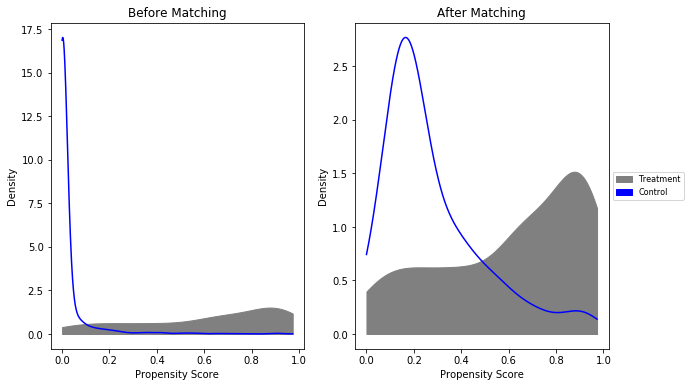

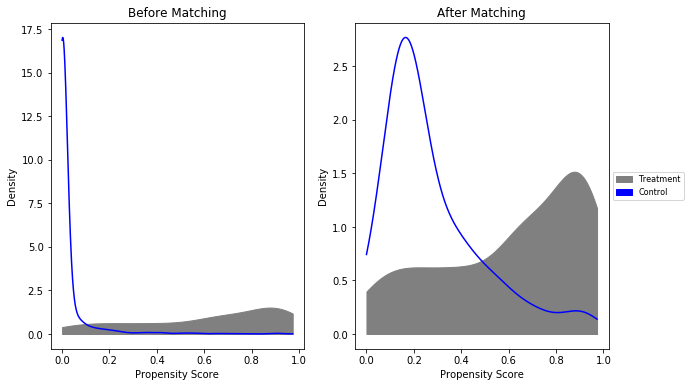

In [105]:
f = plotMatching(df, 'Propensity Score', 'TREAT', matches);display(f)

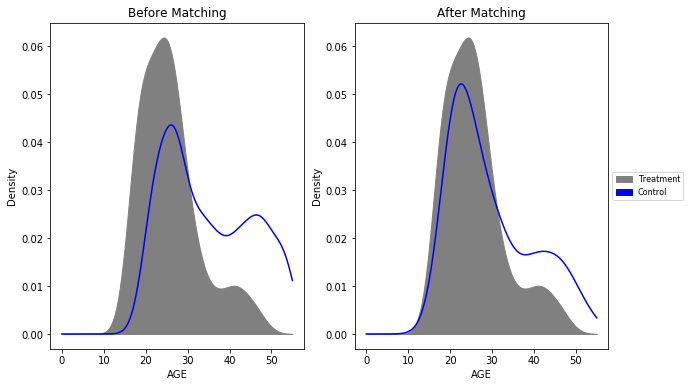

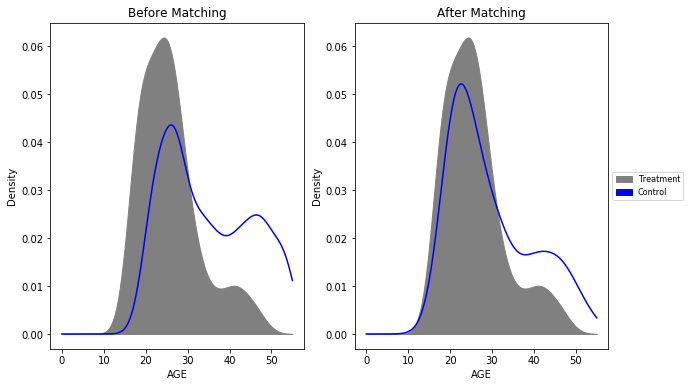

In [106]:
f = plotMatching(df, 'AGE', 'TREAT', matches);display(f)

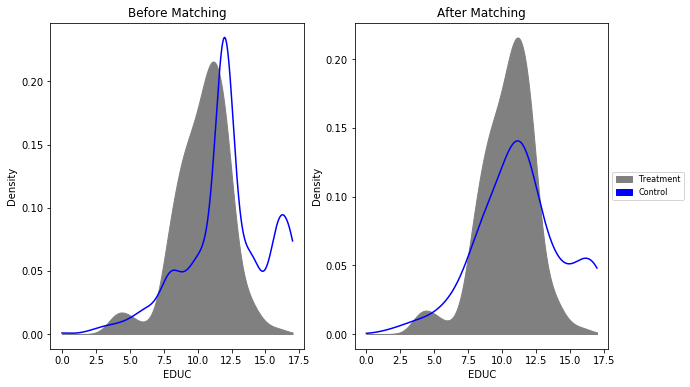

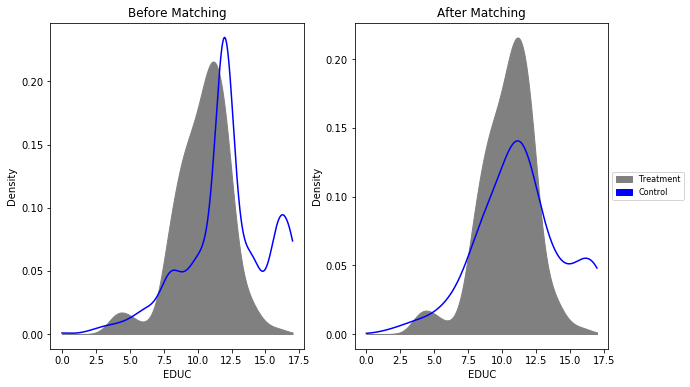

In [107]:
f = plotMatching(df, 'EDUC', 'TREAT', matches);display(f)

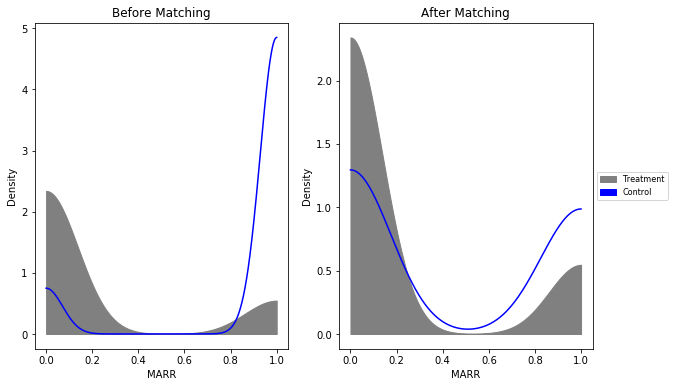

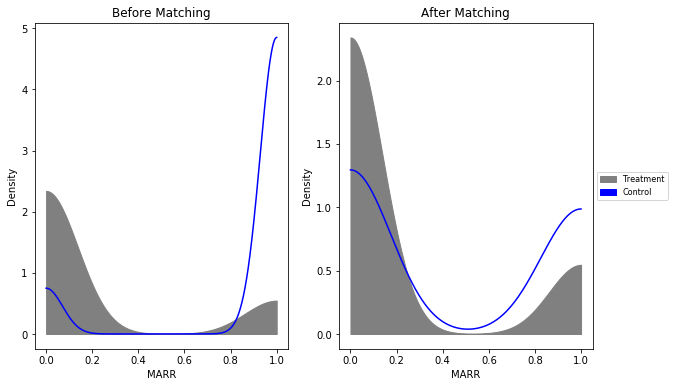

In [108]:
f = plotMatching(df, 'MARR', 'TREAT', matches);display(f)

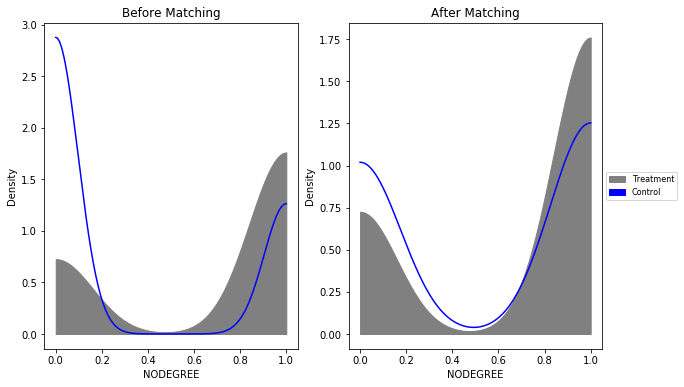

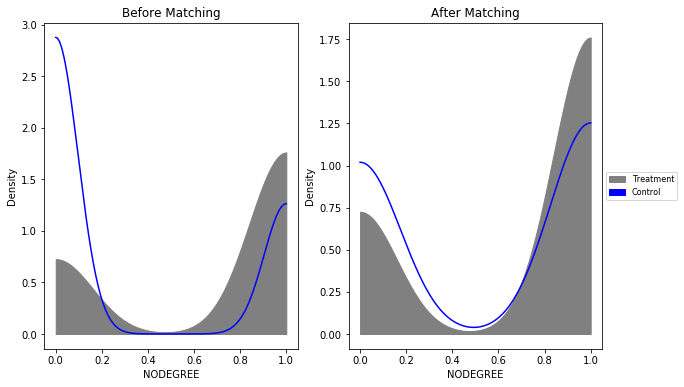

In [109]:
f = plotMatching(df, 'NODEGREE', 'TREAT', matches);display(f)

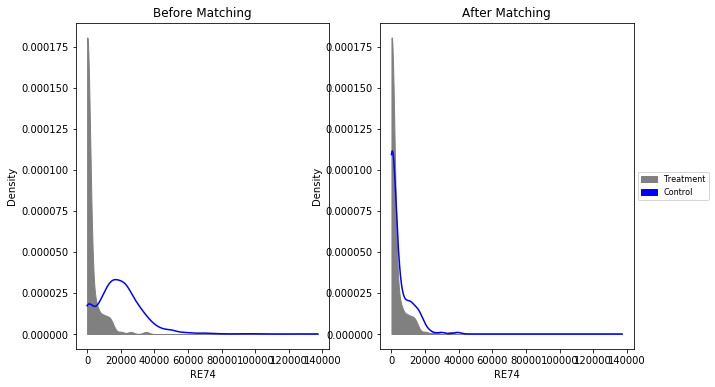

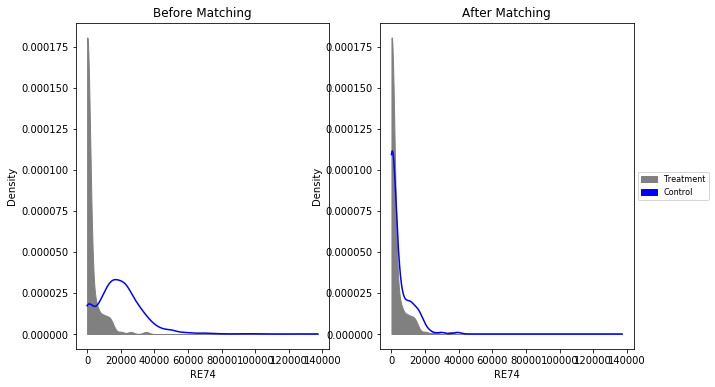

In [110]:
f = plotMatching(df, 'RE74', 'TREAT', matches);display(f)

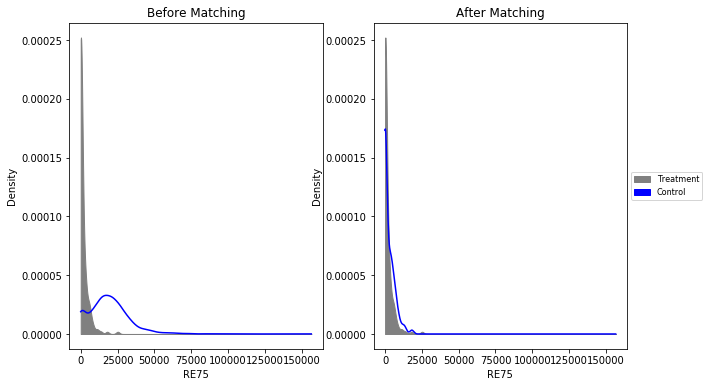

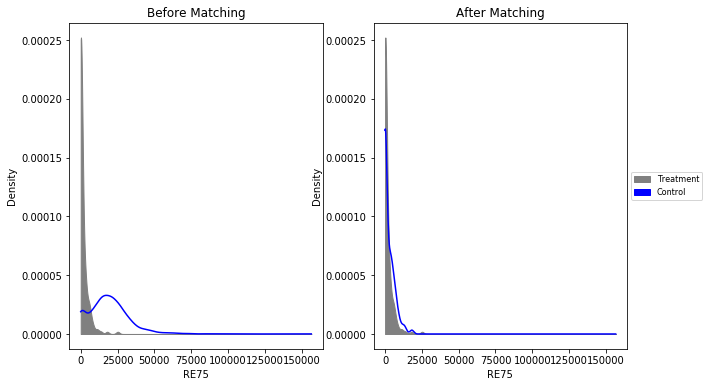

In [111]:
f = plotMatching(df, 'RE75', 'TREAT', matches);display(f)

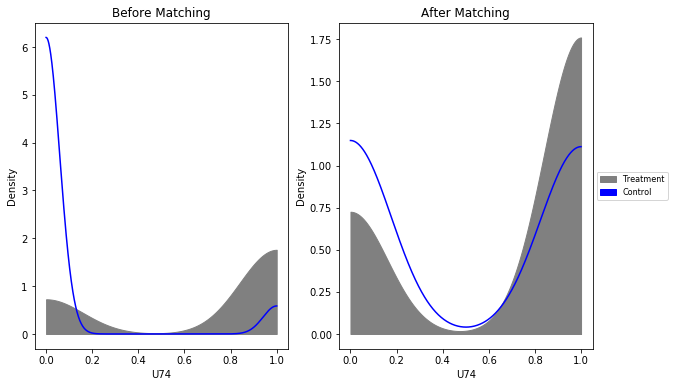

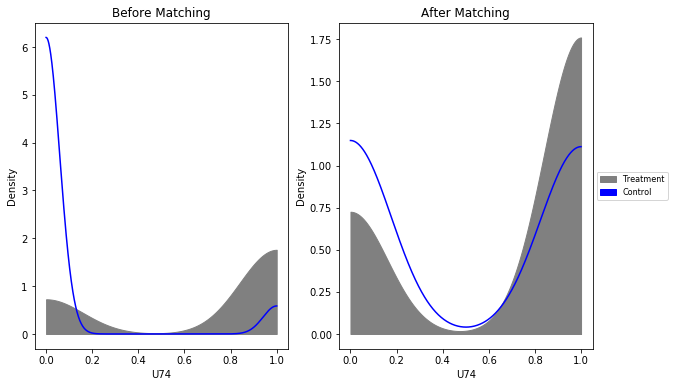

In [112]:
f = plotMatching(df, 'U74', 'TREAT', matches);display(f)

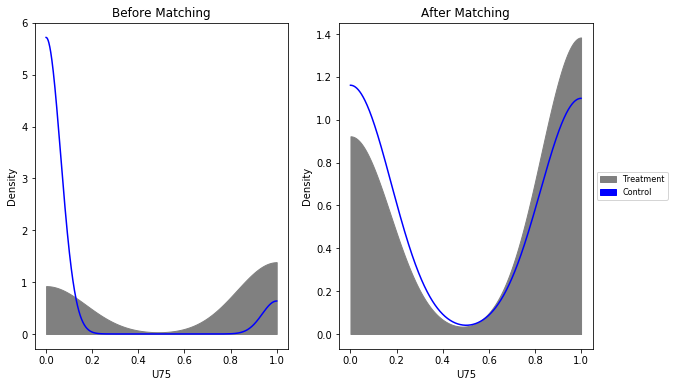

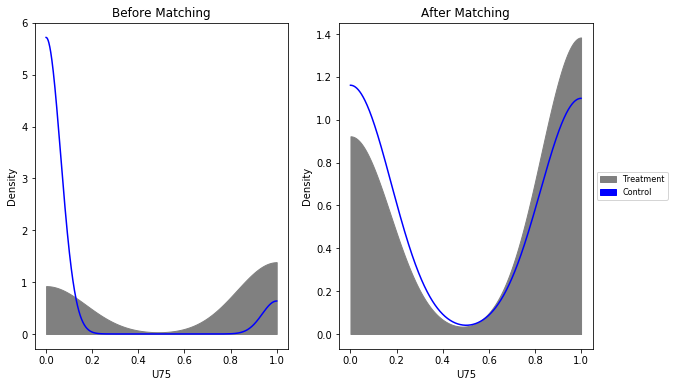

In [113]:
f = plotMatching(df, 'U75', 'TREAT', matches);display(f)

### 4.2 Difference-in-means

In [114]:
def balanceCheck(data, attribute, group):
    means = data[[group, attribute]].groupby(group).mean().reset_index()
    dist = abs(means.diff()).ix[1]
    std = data[[group, attribute]].groupby(group).std().reset_index()
    n = data[group].value_counts()
    se = std.apply(lambda s: np.sqrt(s[0]**2/n[0] + s[1]**2/n[1]))
    tablelist = []
    tablerow = [attribute,dist[1],se[1]]
    tablelist.append(tablerow)
    out = pd.DataFrame(tablelist)
    out.columns = ['Attribute','difference of means by group','Standard error for covariates by group']
    return out

In [115]:
b = pd.DataFrame()
for att in X:
    a = []
    a = balanceCheck(df, att, 'TREAT')
    b = pd.concat([b,a],0)
b

,Attribute,difference of means by group,Standard error for covariates by group
0,AGE,9.034386,0.566131
0,EDUC,1.770922,0.160213
0,MARR,0.677076,0.029669
0,NODEGREE,0.402887,0.034764
0,RE74,17333.171305,448.622995
0,RE75,17531.281123,360.925463
0,U74,0.621763,0.033986
0,U75,0.500000,0.036613


In [116]:
b = pd.DataFrame()
for att in X:
    a = []
    a = hypothesisTest(df_matched, att, 'TREAT')
    b = pd.concat([b,a],0)
b

,Attribute,Mean Difference,t-value,p-value,95% Confidence Intervals,Cohen's d
0,AGE,-3.967568,-4.484631,9.773921e-06,-6.0 - -2.0,-0.466290
0,EDUC,-1.000000,-3.621312,3.342126e-04,-2.0 - -0.0,-0.376526
0,MARR,-0.243243,-5.224625,2.928614e-07,-0.0 - -0.0,-0.543231
0,NODEGREE,0.156757,3.155596,1.733644e-03,0.0 - 0.0,0.328103
0,RE74,-2079.845178,-3.490650,5.403397e-04,-3252.0 - -908.0,-0.362941
0,RE75,-1103.628126,-3.079529,2.229036e-03,-1808.0 - -399.0,-0.320194
0,U74,0.216216,4.340275,1.841251e-05,0.0 - 0.0,0.451280
0,U75,0.113514,2.200085,2.842188e-02,0.0 - 0.0,0.228754


Difference in means for covariates is not significant anymore and the effect sizes are negligible.

## 5 Estimate treatment effects

Estimate average treatment effect  on the treated

### 5.1 Computes ATT using difference in means

In [117]:
# Matched outcome
Y0_matched = df_matched.EARNINGS[df.TREAT == 0]
Y1_matched = df_matched.EARNINGS[df.TREAT == 1]

print ('Differene in means: $'+ str(int(Y1_matched.mean() - Y0_matched.mean())) )

Differene in means: $270
